<a href="https://colab.research.google.com/github/Doclikam/Causal-inference-for-Treatment-Effects-in-Head-Neck-Radiotherapy./blob/main/RADCURE_causal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RADCURE - CHEMOTHERAPY/RADIOTHERAPY HEAD AND NECK CANCER RESPONSE**

Head and Neck Cancers (HNCs) account for > 900,000 cases and 390,000 deaths annually worldwide(Iwatsubo et al, 2019). Radiotherapy (RT) is a foundational treatment. However, many patients receive chemoradiotherapy (ChemoRT), adding systemic chemotherapy to improve tumor control. Radiotherapy (RT) forms the cornerstone of curative treatment for locally advanced disease. In many patients, particularly those with aggressive tumor biology or advanced nodal involvement((T,N,M stage) chemotherapy is added concurrently with radiotherapy (chemoradiotherapy, ChemoRT) with the aim of enhancing tumor cytotoxicity.



**Key definitions:**

Treatment (T): The intervention or exposure (ie: radiotherapy, chemotherapy+radiotherapy, Radiotherapy+EGFRI).

Outcome (Y): The endpoint of interest (e.g., survival time, best response, vitality status, recurrence).

Confounders (X): Variables that influence both treatment and outcome (e.g.age, sex, smoking_status, smoking_pack_years, ECOG performance status, T, N, M, Stage, HPV status, Pathology group, Primary site, Subsite)
                       

While preprocessing teh dat we need to need to keep in mind these:


**Assumptions of Cuasal Machine Learning**

Positivity(overlap):  Every patient must have a non-zero probability of receiving either treatment option, given their baseline confounders.

Consistency (SUTVA):
Each patient’s outcome corresponds to the treatment they received, with no interference across patients.

Conditional Exchangeability:
Given baseline confounders 𝑋 treatment assignment 𝐴 is independent of potential outcomes:

                                        Y(a)⊥A∣X
Ignorability

Ignorability assumes that after adjusting for all measured confounders,
treatment assignment is ‘as good as random.’
This assumption allows us to estimate causal effects from observational data





  DIrected Acyclic Graph
  
  Age,sex,HPV, TNM staging, ECOG,  Smoking, Subsite, Path.            
  
          ↓        ↓
          ↓  Treatment (Chemo+RT vs RT)
          ↓       ↓
       ┌────────────┬────────────┐
       ↓            ↓            ↓
    OS Event     PFS Event    Recurrence

In [28]:
#main libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from datetime import datetime

# Display all columns
pd.set_option('display.max_columns', None)

In [29]:
original_radcure_data = pd.read_excel("/content/RADCURE_Clinical_v04_20241219.xlsx")#load the excel file
original_radcure_data.head(2)#visulize the first 2 patients

,patient_id,Age,Sex,ECOG PS,Smoking PY,Smoking Status,Ds Site,Subsite,T,N,M,Stage,Path,HPV,Tx Modality,Chemo,RT Start,Dose,Fx,Last FU,Status,Length FU,Date of Death,Cause of Death,Local,Date Local,Regional,Date Regional,Distant,Date Distant,2nd Ca,Date 2nd Ca,RADCURE-challenge,ContrastEnhanced
0,RADCURE-0005,62.6,Female,ECOG 0,50,Ex-smoker,Oropharynx,post wall,T4b,N2c,M0,IVB,Squamous Cell Carcinoma,"Yes, Negative",RT alone,none,2002-02-20,60.0,25,2003-05-12,Dead,1.317808,2003-05-12,Other Cause,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,0
1,RADCURE-0006,87.3,Male,ECOG 2,25,Ex-smoker,Larynx,Glottis,T1b,N0,M0,I,Squamous Cell Carcinoma,NaN,RT alone,none,2006-01-17,51.0,20,2007-06-28,Dead,1.520548,2007-06-28,Other Cause,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,1


In [30]:
#standardize column names
original_radcure_data.columns = original_radcure_data.columns.str.strip().str.lower()

In [32]:
#Columns
original_radcure_data.columns

Index(['patient_id', 'age', 'sex', 'ecog ps', 'smoking py', 'smoking status',
       'ds site', 'subsite', 't', 'n', 'm', 'stage', 'path', 'hpv',
       'tx modality', 'chemo', 'rt start', 'dose', 'fx', 'last fu', 'status',
       'length fu', 'date of death', 'cause of death', 'local', 'date local',
       'regional', 'date regional', 'distant', 'date distant', '2nd ca',
       'date 2nd ca', 'radcure-challenge', 'contrastenhanced'],
      dtype='object')

In [33]:
original_radcure_data.duplicated().sum()

np.int64(0)

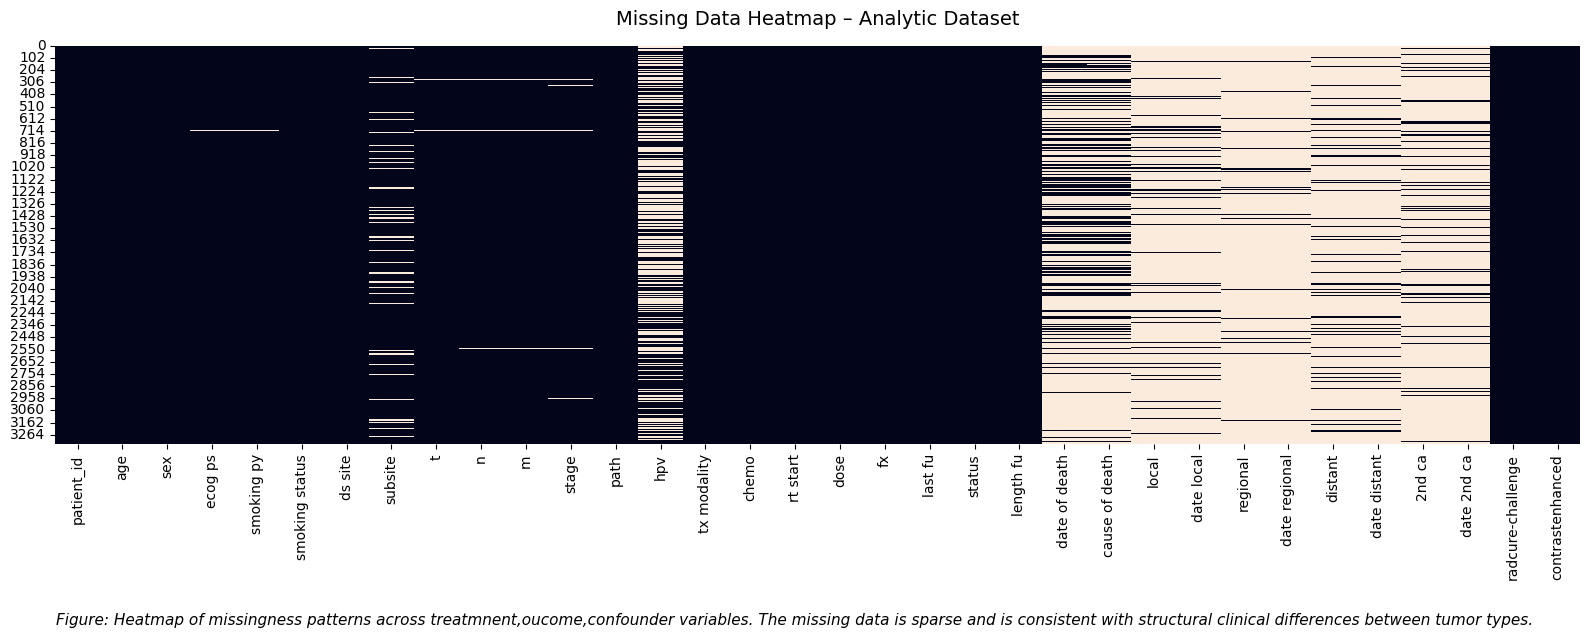

In [6]:
#missing data heatmap
plt.figure(figsize = (16,6))
sns.heatmap(original_radcure_data.isna(), cbar= False)
plt.title("Missing Data Heatmap – Analytic Dataset", fontsize=14, pad=15)

plt.figtext(
    0.5, -0.05,
    "Figure: Heatmap of missingness patterns across treatmnent,oucome,confounder variables. "
    "The missing data is sparse and is consistent with structural clinical differences between tumor types.",
    wrap=True, ha='center', fontsize=11, style='italic'
)

plt.tight_layout()
plt.savefig('missing_data_heatmap.png', bbox_inches='tight', dpi=300)
plt.show()

In [7]:
#create a copy of the dataset
radcure_data= original_radcure_data.copy()

# Define Exposure (Treatment)

We limit to a **binary** clinical decision made at baseline:

- `ChemoRT`: Chemotherapy + Radiotherapy
- `RT-alone`: Radiotherapy alone

Patients receiving postoperative radiotherapy (n=3) or radiotherapy combined with EGFR inhibitors (n=72) were excluded from the primary causal contrast, as these regimens represent distinct treatment pathways with different biological mechanisms. The primary comparison was therefore between definitive radiotherapy alone and concurrent chemoradiation.

In [8]:
#harmonize the treatment modality from 'RT alone', 'ChemoRT', 'RT + EGFRI', 'ChemoRT ', 'Postop RT alone'
radcure_data["tx_modality"] = radcure_data["tx modality"].str.lower().str.strip()

radcure_data['tx_modality_clean'] = radcure_data['tx_modality'].replace({
    'rt alone': 'rt_alone',
    'chemort': 'chemort',
    'rt + e gfri': 'rt_egfri',  # ensure mapping correct
    'postop rt alone': 'postop_rt'
})

#check unique treatment modalities
print("\nUnique treatment modalities (cleaned):")
print(radcure_data['tx_modality_clean'].value_counts(dropna=False))


Unique treatment modalities (cleaned):
tx_modality_clean
rt_alone      1858
chemort       1413
rt + egfri      72
postop_rt        3
Name: count, dtype: int64


 Patients treated with RT + EGFR inhibitors (N=72) and Post operative Radiotherapy patients (N= 3) were excluded from the primary causal analysis. This RT + EGFR inhibitors- subgroup is typically selected based on inability to tolerate chemotherapy or specific tumor biology (e.g., HPV+ OPC), resulting in structural differences in baseline prognosis. Inclusion would violate the positivity assumption, as these patients had near-zero probabilities of receiving either RT-alone or ChemoRT given their clinical characteristics.
 We will use Radioatherapy and Radiotehrapy+ Chemotherapy as the treatment exposure.

In [9]:
#Our treatment (Radiotherapy alone vs Radiotherapy +chemotherapy)
#Primary causal exposure: chemo(addon) vs RT only
rad_data= radcure_data[
    radcure_data['tx_modality_clean'].isin(['rt_alone','chemort'])
].copy()
rad_data['treatment'] = (rad_data['tx_modality_clean'] == 'chemort').astype(int)

print("\n Treatment: ( 0= Radiation alone, 1=Chemoradiation)")
print(rad_data['treatment'].value_counts())



 Treatment: ( 0= Radiation alone, 1=Chemoradiation)
treatment
0    1858
1    1413
Name: count, dtype: int64


 # Downstream treatment components

This include RT dose, dose per fraction, number of fractions, treatment duration, and calculated(BED/EQD2). This are not pre-treatment characteristics they are part of the treatment itself.Adjusting for dose/fractions would remove part of the treatment’s real effect by blocking part of the causal pathway.  


Different RT fractionation and total dose can change biological effect, two patients with same total dose but different fraction sizes have different biological impact.
1. BED(Biologically Effective Dose)

       BED=n⋅d⋅(1+ d/α/β)
        Where:
              n = number of fractions

              d = dose per fraction (Gy)

              α/β = tissue-specific parameter (Gy)


2. EQD2 (Equivalent Dose in 2 Gy fractions)


       EQD2=BED/(1+2/(α/β))


3. BED_eff (BED corrected for treatment efficiency / repopulation)

        BED_eff = n * d * (1 + d / alpha_beta) - k * (T - T_kickoff
        Where:

            k = dose loss per day due to tumor repopulation (Gy/day)

            T = overall treatment time (days)

            kickoff = time after which repopulation starts (days)
	​

In [10]:
def compute_bed_eqd2(df, dose_col='Dose', fx_col='Fx', days_col=None,
                     alpha_beta=10.0,Tk=21.0):
    """
    Compute BED, EQD2, and BED_eff for radiotherapy.

    Parameters:
    df : DataFrame
        Input dataframe containing total dose, fractions, and optionally total RT days.
    dose_col : str
        Column name for total radiation dose (Gy).
    fx_col : str
        Column name for number of fractions.
    days_col : str or None
        Column name for total treatment duration (days). Required for repopulation correction.
    alpha_beta : float
        Alpha/Beta ratio for tumor tissue (default=10 Gy for HNSCC).

    """
    df = rad_data.copy()

    # Ensure necessary columns exist
    if fx_col not in df.columns:
        raise ValueError(f"Missing column '{fx_col}' for fractions count.")
    if dose_col not in df.columns:
        raise ValueError(f"Missing column '{dose_col}' for total dose.")

    # Compute dose per fraction
    df['d_per_fx'] = df[dose_col].astype(float) / df[fx_col].astype(float)
    df['num'] = df[fx_col].astype(float)

    # BED (no repopulation)
    d = df['d_per_fx']
    num = df['num']
    df['BED'] = num * d * (1 + d / alpha_beta)

    # EQD2
    df['EQD2'] = df['BED'] / (1 + 2.0 / alpha_beta)
    return df


# Apply the function
# α/β = 10 Gy for tumor control

rad_data = compute_bed_eqd2(
    rad_data,
    dose_col='dose',
    fx_col='fx',
    days_col='length fu',
    alpha_beta=10.0,
    Tk=21
)

#summary stats
print("\n BED & EQD2 computed successfully.")
print(rad_data[['dose','fx','d_per_fx','BED','EQD2']].describe().round(2))



 BED & EQD2 computed successfully.
          dose       fx  d_per_fx      BED     EQD2
count  3271.00  3271.00   3271.00  3271.00  3271.00
mean     66.60    32.99      2.05    80.19    66.82
std       5.79     5.26      0.23     6.27     5.22
min      50.00    20.00      1.10    57.25    47.71
25%      64.00    35.00      2.00    74.40    62.00
50%      70.00    35.00      2.00    84.00    70.00
75%      70.00    35.00      2.00    84.00    70.00
max      74.00    60.00      2.75    88.80    74.00


## Survival Outcomes


Overall Survival: Time from start of radiotherapy (rt_start) to death from any cause.

If the patient is alive, the last follow-up date (last_fu) is used : censored observation.


- Time zero = **RT Start**
- Event = **death from any cause**
- Censoring = Last follow-up if alive
- All times in **days**
-Progression-Free Survival (PFS)- Time from radiotherapy start until first recurrence or death, whichever occurs first.

Recurrence = local, regional, or distant failure.

Composite endpoints (local/regional/distant recurrence, PFS) are built without removing patients lacking event dates.

We need to enure that there is no patient with:
 Missing RT start = invalid time zero.

Missing last follow-up = no censoring point.

Negative or zero OS time = impossible timeline.

Death after follow-up = temporal inconsistency.

In [11]:
#rename event cols
event_cols = ['rt start', 'last fu','length fu', 'date of death', 'cause of death', 'local',
             'date local', 'regional', 'date regional', 'distant',
             'date distant', '2nd ca', 'date 2nd ca']

# build mapping only for columns that exist in rad_data
rename_map = {
    c: c.strip().lower().replace(" ", "_").replace("-", "_")
    for c in event_cols if c in rad_data.columns
}

rad_data.rename(columns=rename_map, inplace=True)

#Only date columns to parse (true dates only)
date_cols = [
    "rt_start", "last_fu", "date_of_death",
    "date_local", "date_regional", "date_distant", "date_2nd_ca"
]
print("\nParsed date columns overview:")
print(rad_data[date_cols].dtypes)

for c in date_cols:
    if c in rad_data.columns:
        # set column to dates errors='coerce' -> NaT if unparseable
        rad_data[c] = pd.to_datetime(rad_data[c], errors="coerce")

# Overall survival (OS)
rad_data["os_end"] = rad_data["date_of_death"].fillna(rad_data["last_fu"])
rad_data["time_os_days"] = (rad_data["os_end"] - rad_data["rt_start"]).dt.days
rad_data["event_os"] = rad_data["date_of_death"].notna().astype(int)

# Exclude patients who died before they received RT
exclude_pre_rt_death = (
    rad_data['event_os'].eq(1) &
    (rad_data['date_of_death'] <= rad_data['rt_start'])
)

print("Excluding patients:", exclude_pre_rt_death.sum())

print()

# flags (do not drop — only flag)
rad_data["bad_time_zero"]  = rad_data["rt_start"].isna().astype(int)
rad_data["bad_followup"]   = rad_data["last_fu"].isna().astype(int)
rad_data["neg_or_zero_os"] = (
    rad_data["time_os_days"].isna() | (rad_data["time_os_days"] <= 0)
).astype(int)
rad_data["death_after_fu"] = (
    rad_data["event_os"].eq(1) & (rad_data["date_of_death"] > rad_data["last_fu"])
).astype(int)

print("\n Summary")
print(rad_data[["bad_time_zero", "bad_followup", "neg_or_zero_os", "death_after_fu"]].sum())
print(f"\nTotal patients flagged for any QC issue: {(rad_data[['bad_time_zero', 'bad_followup', 'neg_or_zero_os', 'death_after_fu']].sum(axis=1) > 0).sum()}")

# Event flags from the start of treatment: 1 if that event occurred, 0 otherwise
for site in ["local", "regional", "distant", "2nd_ca"]:
    date_col = f"date_{site}"
    if date_col in rad_data.columns:
        rad_data[f"event_{site}"] = rad_data[date_col].notna().astype(int)
    else:
        rad_data[f"event_{site}"] = 0

# Time-to-event (only for rows with that event) from treatment start
#If event didn’t occur: leave as NaN (censored)
for site in ["local", "regional", "distant"]:
    date_col = f"date_{site}"
    if date_col in rad_data.columns:
        rad_data[f"time_{site}_days"] = np.where(
            rad_data[f"event_{site}"] == 1,
            (rad_data[date_col] - rad_data["rt_start"]).dt.days,
            np.nan
        )
# print event counts
print("Event counts (any recurrence):")
print(rad_data[["event_local","event_regional","event_distant","event_2nd_ca"]].sum())



# Progression-Free Survival (first of any recurrence OR death)
#time_pfs_days: Time from RT start to earliest progression or death
#event_pfs: 1 = progression/death, 0 = censored
pfs_sources = [c for c in ["date_local","date_regional","date_distant","date_of_death"] if c in rad_data.columns]
if pfs_sources:
    pfs_end = pd.concat([rad_data[c] for c in pfs_sources], axis=1).min(axis=1)
    rad_data["time_pfs_days"] = (pfs_end - rad_data["rt_start"]).dt.days
    rad_data["event_pfs"] = (
        (rad_data[["event_local","event_regional","event_distant"]].sum(axis=1) > 0) |
        (rad_data["event_os"] == 1)
    ).astype(int)
    # Censor PFS at last FU if no event
    rad_data.loc[rad_data["event_pfs"] == 0, "time_pfs_days"] = (
        rad_data["last_fu"] - rad_data["rt_start"]
    ).dt.days
print(f"PFS computed for {rad_data['time_pfs_days'].notna().sum()} patients.")
print(f"Median Progress Free Survival (PFS) (days): {rad_data['time_pfs_days'].median():.0f}")

# Follow-up (descriptive)
rad_data["followup_days"] = (rad_data["last_fu"] - rad_data["rt_start"]).dt.days

#set non-positive times to NaN
for col in ["time_os_days","time_pfs_days","time_local_days","time_regional_days","time_distant_days","followup_days"]:
    if col in rad_data.columns:
        rad_data.loc[rad_data[col] <= 0, col] = np.nan




Parsed date columns overview:
rt_start         datetime64[ns]
last_fu          datetime64[ns]
date_of_death    datetime64[ns]
date_local       datetime64[ns]
date_regional    datetime64[ns]
date_distant     datetime64[ns]
date_2nd_ca      datetime64[ns]
dtype: object
Excluding patients: 0


 Summary
bad_time_zero     0
bad_followup      0
neg_or_zero_os    0
death_after_fu    0
dtype: int64

Total patients flagged for any QC issue: 0
Event counts (any recurrence):
event_local       368
event_regional    184
event_distant     403
event_2nd_ca      428
dtype: int64
PFS computed for 3271 patients.
Median Progress Free Survival (PFS) (days): 1145


In [12]:
print("Total patients before treatment selection:", 3346)
print("Totalpatients  after treatment selection:", len(rad_data))

print("\n Deceased before:", 1058)
print("Deceased after:", rad_data['event_os'].sum())

Total patients before treatment selection: 3346
Totalpatients  after treatment selection: 3271

 Deceased before: 1058
Deceased after: 1021


For radiotherapy+EGFR their mortality is much higher than typical ChemoRT or RT-onlly 35 of the 72 treated with Radio+EGFRI are deceased.  Hence there is; Severe case mix difference, no overlap, they cannot be weighted to comparability

# **Confounder processing**

**Confounders**

age, sex, ECOG PS,TNM stage, HPV, primary site, Smoking status, pack-years,staging completeness, HPV testing

# Age

Age is a confounder in the causal analysis because it influences both treatment selection and survival outcomes. Epidemiological studies in head-and-neck cancer have shown that each additional decade of age is associated with progressively worse overall survival, making adjustment essential for unbiased effect estimation.

# Smoking — baseline behavioral risk factor

Both pack-years and status influence:
- treatment choice (Chemo vs RT)
- survival

Smoking is a critical determinant of tumor biology and treatment response in head and neck squamous cell carcinoma (HNSCC). Tobacco exposure contributes can contribute to  decreased radiosensitivity, which can adversely affect local control and survival outcomes. Furthermore, smoking modifies the prognostic impact of HPV status, as HPV-positive tumors in current or former smokers exhibit poorer outcomes compared to HPV-positive tumors in never-smokers. Therefore, stratifying patients by smoking behavior (current, ex-, non-smoker) provides a clinically meaningful adjustment for biological heterogeneity and treatment effect modification.


                 

In [13]:
rad_data['smoking status'].value_counts()

,count
smoking status,
Ex-smoker,1254
Current,1121
Non-smoker,851
unknown,45


In [14]:
#Smoking status
rad_data['smoking_status_clean'] = (
    rad_data['smoking status'].astype(str).str.strip().str.title()
)
print("\n Smoking status categories (cleaned):")
print(rad_data['smoking_status_clean'].value_counts(dropna=False))

#We have "na" values in our dataset that are not accounted for in the missingnes and inconsistencies such as >5, <20
# clean smoking pack-year column
rad_data["smoking_py_clean"] = (
    rad_data["smoking py"]
    .astype(str)
    .str.strip()
    .replace({"na": np.nan, "NA": np.nan, "NaN": np.nan, "": np.nan})
)

# Clean pack years strings
def clean_smoking_py(value):
    if pd.isna(value): return np.nan
    v = str(value).strip().lower()

    if v.startswith("<"):
        try: return float(v[1:]) / 2
        except: return np.nan

    if v.startswith(">"):
        try: return min(float(v[1:]) + 5, 120)
        except: return np.nan

    try:
        return float(v)
    except:
        return np.nan

rad_data['smoking_py_clean'] = rad_data['smoking py'].apply(clean_smoking_py)

# Inconsistency flags
rad_data['smoking_mismatch_flag'] = (
    ((rad_data['smoking_status_clean'] == 'Non-Smoker') &
     (rad_data['smoking_py_clean'] > 0)) |
    ((rad_data['smoking_status_clean'].isin(['Ex-Smoker','Current'])) &
     (rad_data['smoking_py_clean'].isna() | (rad_data['smoking_py_clean'] == 0)))
).astype(int)
print("\n Inconsistencies detected and flagged:")
print(rad_data['smoking_mismatch_flag'].value_counts())

# Correct inconsistencies
rad_data.loc[
    (rad_data['smoking_status_clean'] == 'Non-Smoker') &
    (rad_data['smoking_py_clean'] > 0),
    'smoking_py_clean'
] = 0 #if person is a non-smoker and has values other than 0 replace with 0

rad_data.loc[
    (rad_data['smoking_status_clean'].isin(['Ex-Smoker','Current'])) &
    (rad_data['smoking_py_clean'] == 0),
    'smoking_py_clean'
] = np.nan #if person has smoked/currenty smoking and has 0 pack years replace with np.nan

# Missingness indicator
rad_data['smoking_py_missing'] = rad_data['smoking_py_clean'].isna().astype(int)
print("🚭 Missing pack-years after cleaning:", rad_data['smoking_py_missing'].sum())
print("-" * 60)


print("\n combined view (sample of 5):")
print(
    rad_data[['smoking status', 'smoking_status_clean',
               'smoking py', 'smoking_py_clean',
               'smoking_mismatch_flag']].sample(5, random_state=42))


 Smoking status categories (cleaned):
smoking_status_clean
Ex-Smoker     1254
Current       1121
Non-Smoker     851
Unknown         45
Name: count, dtype: int64

 Inconsistencies detected and flagged:
smoking_mismatch_flag
0    3261
1      10
Name: count, dtype: int64
🚭 Missing pack-years after cleaning: 55
------------------------------------------------------------

 combined view (sample of 5):
     smoking status smoking_status_clean smoking py  smoking_py_clean  \
1666     Non-smoker           Non-Smoker          0               0.0   
135      Non-smoker           Non-Smoker          0               0.0   
422      Non-smoker           Non-Smoker          0               0.0   
205       Ex-smoker            Ex-Smoker          2               2.0   
1178      Ex-smoker            Ex-Smoker          1               1.0   

      smoking_mismatch_flag  
1666                      0  
135                       0  
422                       0  
205                       0  
1178     

 ### Disease Site And Subsite

The primary tumor site is an essential variable because therapeutic approaches and biological behavior differ across subsites of HNSCC. While definitive chemoradiotherapy (CRT) is standard for locally advanced cancers of the oropharynx, larynx, and hypopharynx, early oral cavity lesions often require surgery with adjuvant therapy. HPV association is particularly relevant in oropharyngeal squamous cell carcinoma (OPSCC), where HPV-positive and HPV-negative tumors represent distinct disease entities with different prognoses and treatment sensitivities. Including tumor site allows accurate subgroup analysis and avoids inappropriate generalization of HPV-related findings to non-oropharyngeal tumors.


 Mapped into **4 clinically meaningful groups**:
- Oropharynx
- Larynx
- Nasopharynx
- Other_HNC

Subsite included **only** for Oro/Larynx where relevant and complete

In [15]:
#lower case for consistent naming of the tumor sites.
rad_data['ds_site'] = rad_data['ds site'].astype(str).str.lower().str.strip()

# map for consistent naming of the DS site
primary_site_map = {
    'nasal cavity': 'nasal cavity',
    'nasal cavity ': 'nasal cavity',
    'esophagus': 'esophagus',
    'lip & oral cavity': 'lip_oral_cavity'
}
rad_data['ds_site_clean'] = rad_data['ds_site'].replace(primary_site_map)

#for casual modelling we will use four main groups.
def primary_group(site):
    if 'oropharynx' in site:
        return "Oropharynx"
    if 'larynx' in site:
        return "Larynx"
    if 'nasopharynx' in site:
        return "Nasopharynx"
    if 'hypopharynx' in site:
        return "Hypopharynx"
    return "Other_HNC"

#apply this changes
rad_data['primary_site_group'] = rad_data['ds_site_clean'].apply(primary_group)

print("Sample of cleaned site names:")
print(rad_data['ds_site_clean'].value_counts().head(5))
print("\nPrimary site grouping distribution:")
print(rad_data['primary_site_group'].value_counts())

Sample of cleaned site names:
ds_site_clean
oropharynx     1453
larynx          867
nasopharynx     355
unknown         167
hypopharynx     154
Name: count, dtype: int64

Primary site grouping distribution:
primary_site_group
Oropharynx     1453
Larynx          867
Other_HNC       442
Nasopharynx     355
Hypopharynx     154
Name: count, dtype: int64


In [16]:
#handle the missingness of subsite
rad_data['subsite_clean'] = rad_data['subsite'].astype(str).str.strip().str.title()


# we subsite that are flagged as valid; clinically relevant & low missingness
flagged_subsite_sites = ["Oropharynx", "Larynx"]
rad_data.loc[
    ~rad_data['primary_site_group'].isin(flagged_subsite_sites),
    'subsite_clean'
] = np.nan  # Remove meaningless subsites

# Subsite missingness indicator only within valid groups to identify true missingness rather than structural
rad_data['subsite_missing'] = (
    rad_data['subsite_clean'].isna() &
    rad_data['primary_site_group'].isin(flagged_subsite_sites)
).astype(int)

print(
    rad_data.groupby('primary_site_group')['subsite_missing']
    .agg(['sum', 'count'])
    .assign(pct_missing=lambda x: 100 * x['sum'] / x['count'])
    .round(1)
    .sort_values('pct_missing', ascending=False)
)

print("\nTotal missing subsites (within valid sites):", rad_data['subsite_missing'].sum())

                    sum  count  pct_missing
primary_site_group                         
Hypopharynx           0    154          0.0
Larynx                0    867          0.0
Nasopharynx           0    355          0.0
Oropharynx            0   1453          0.0
Other_HNC             0    442          0.0

Total missing subsites (within valid sites): 0


# Path

The variable path include histological tumor subtypes. These affect  both treatment choice and prognosis

Grouping the confounders : SCC , NPC / Other epithelial,  Other rare; grouping protects positivity.

In [17]:
rad_data['path'].value_counts()

,count
path,
Squamous Cell Carcinoma,2773
NPC: Type 3 (WHO IIB),283
"NPC, Type 2 (WHO IIA)",60
Squamous Cell Carcinoma In-Situ,46
Adenoid Cystic,14
"NPC, Type 1 (WHO I)",11
Neuroendocrine ca (small cell),10
Adenosquamous Cell,8
Paraganglioma,7


In [18]:
def map_pathology(x: str):
    if pd.isna(x):
        return "Other_rare"
    s = str(x).strip().lower()

    # SCC tumors(catch common variants & case variants)
    if ("squamous" in s) or ("scc" in s) or ("verrucous" in s) or ("in-situ" in s):
        return "SCC"

    # NPC tumors (WHO I–III / type 1–3)
    if ("npc" in s) or ("nasopharyngeal" in s) or ("who ii" in s) or ("who i" in s) or ("who iii" in s):
        return "NPC"

    # Other epithelial (salivary/adenocarcinoma family, adenoid cystic, adenosquamous, basaloid, clear cell)
    if any(k in s for k in [
        "adenoid cystic", "adenocystic", "adeno", "salivary duct",
        "basaloid", "clear cell", "microcystic adnexal", "sebaceous"
    ]):
        return "Other_epithelial"

    # Other tumors: sarcomas, melanoma, snuc, nut midline, merkel, plasmacytoma, undiff, neuroendocrine)
    return "Other_rare"

#map this new classes
rad_data['pathology_group'] = rad_data['path'].apply(map_pathology)
#Check distribution of new groups
print("\nPathology group counts:")
print(rad_data['pathology_group'].value_counts(dropna=False))


Pathology group counts:
pathology_group
SCC                 2832
NPC                  354
Other_rare            59
Other_epithelial      26
Name: count, dtype: int64


In [19]:
print(rad_data['n'].dropna().unique()[:30])

['N2c' 'N0' 'N2b' 'N2a' 'N1' 'N2' 'N3' 'N3b' 'N3a' 'NX']


### Tumor Extent at Diagnosis (TNM and Stage)

TNM missingness is **informative**.
We:
- preserve missing values
- add missingness flags
- distinguish **structural** vs **statistical** missing

In [20]:
original_radcure_data['n'].value_counts()

,count
n,
N0,1147
N2b,791
N2c,532
N1,344
N2,182
N3,170
N2a,125
N3b,28
N3a,13


In [21]:
#Flag non-TNM cancers (TNM not applicable)
def identify_non_tnm(site):
    site = str(site).lower()
    if any(x in site for x in ['paraganglioma', 'glomus', 'benign', 'orbit', 'lacrimal']):
        return 1
    return 0

rad_data['is_non_tnm'] = rad_data['ds_site_clean'].apply(identify_non_tnm)

#Flag structural TNM missing
# TNM exists but often not assessed in practice for these sites
rad_data['tnm_structural_missing'] = (
    rad_data['is_non_tnm'] |
    rad_data['ds_site_clean'].str.contains('skin|sarcoma|esophagus', case=False)
).astype(int)

#Remove TNM where not applicable (STRUCTURAL missing)
tnm_cols = ['t', 'n', 'm']
for col in tnm_cols:
    rad_data.loc[rad_data['tnm_structural_missing'] == 1, col] = np.nan

#Missingness flags for TNM (STATISTICAL missing)

for col in tnm_cols:
    rad_data[f'{col}_missing'] = (
        rad_data[col].isna() &
        (rad_data['tnm_structural_missing'] == 0)
    ).astype(int)

print("\n[Check 2] Structural TNM missing flag:")
print(rad_data['tnm_structural_missing'].value_counts(dropna=False))
print(f"→ {rad_data['tnm_structural_missing'].sum()} rows (structural TNM missing)")



#flag stage missing
rad_data['stage_missing'] = rad_data['stage'].isna().astype(int)
print("\nStage missingness rate:")
print(f"→ {100 * rad_data['stage_missing'].mean():.1f}% of records missing stage info")


[Check 2] Structural TNM missing flag:
tnm_structural_missing
0    3185
1      86
Name: count, dtype: int64
→ 86 rows (structural TNM missing)

Stage missingness rate:
→ 0.8% of records missing stage info


###HPV Status

The HPV status is a critically important covariate in head and neck cancer outcomes, and is involved in upto 25% of Hncs, particulary in oropharyngeal cancers. HPV positive tumors have a more favourable diagnosis, and can respond diffrently to radiotherapy and chemotherapy. The HPV column has entries such as :"Yes, positive", "Yes, negative" and missing values. It has 48.7% missingness, ignoring this values could therefore introduce confounding since it is related to the treatment and survival outcomes.Rather than dropiing the missing values, we will introduce a third category "Uknown" to allow the model to learn whether the absence of the test has implications.



We recode:
- HPV_Positive
- HPV_Negative
- HPV_Unknown

In [22]:
rad_data['hpv'].value_counts()

,count
hpv,
"Yes, positive",1104
"Yes, Negative",558


In [23]:
#Normalize the HPV entries to"HPV_positive","HPV_negative" or HPV_unknown
def clean_hpv(value):
    if pd.isna(value):
        return "HPV_Unknown"

    v = str(value).strip().lower()

    if "pos" in v:
        return "HPV_Positive"
    if "neg" in v:
        return "HPV_Negative"

    return "HPV_Unknown"

rad_data['hpv_clean'] = rad_data['hpv'].apply(clean_hpv)
print("\n[Check 1] HPV Cleaned Value Distribution:")
print(rad_data['hpv_clean'].value_counts(dropna=False))


# HPV specific/ relevant tumors ONLY in Oropharynx
rad_data['hpv_specific_tumors'] = (
    rad_data['primary_site_group'].eq("Oropharynx")
).astype(int)


# If HPV not relevant → set to NaN (avoid incorrect confounding)
rad_data.loc[
    rad_data['hpv_specific_tumors'] == 0,
    'hpv_clean'
] = np.nan

# Missingness flag: only meaningful for relevant cancers
rad_data['hpv_missing'] = (
    rad_data['hpv_clean'].isna() &
    rad_data['hpv_specific_tumors'].eq(1)
).astype(int)
print("\nHPV missingness (within relevant tumors):")
print(f"→ {rad_data['hpv_missing'].sum()} missing HPV entries among relevant cancers")



[Check 1] HPV Cleaned Value Distribution:
hpv_clean
HPV_Unknown     1609
HPV_Positive    1104
HPV_Negative     558
Name: count, dtype: int64

HPV missingness (within relevant tumors):
→ 0 missing HPV entries among relevant cancers


# ECOG

The Eastern Cooperative Oncology Group (ECOG) Performance Status is a standardized measure of a patient’s functional ability and self-care capacity, widely used to determine eligibility for cancer therapy and predict prognosis.

| **ECOG Score** | **Description**                                                                                               |
| -------------- | ------------------------------------------------------------------------------------------------------------- |
| **0**          | Fully active; able to carry on all pre-disease performance without restriction.                               |
| **1**          | Restricted in physically strenuous activity but ambulatory; able to perform light or sedentary work.          |
| **2**          | Ambulatory and capable of all self-care but unable to carry out any work activities; up >50% of waking hours. |
| **3**          | Capable of only limited self-care; confined to bed or chair >50% of waking hours.                             |
| **4**          | Completely disabled; cannot carry out any self-care; totally confined to bed or chair.                        |
| **5**          | Dead. *(Used only for survival endpoint definition, not in baseline performance status)*                      |


In [24]:
# ECOG
rad_data['ecog ps'].value_counts()

,count
ecog ps,
ECOG 0,1984
ECOG 1,1000
ECOG 2,205
ECOG 3,40
Unknown,31
ECOG 4,6
ECOG-Pt 2,1
ECOG 0-1,1
ECOG-Pt 0,1


In [25]:
#ECOG performance status
def clean_ecog(value):
    if pd.isna(value): return np.nan
    v = str(value).lower().strip()

    # Handle unknowns
    if 'unknown' in v:
        return np.nan

    # Extract number (handles formats: "ecog 1", "ecog-pt 1", etc.)
    match = re.search(r'(\d)', v)
    if match:
        return int(match.group(1))

    return np.nan  # fallback

rad_data['ecog_ps'] = rad_data['ecog ps'].apply(clean_ecog)
print('\nECOG Performance Status distribution:')
print(rad_data['ecog_ps'].value_counts(dropna=False))

# ECOG missingness flag
rad_data['ecog_ps_missing'] = rad_data['ecog_ps'].isna().astype(int)




ECOG Performance Status distribution:
ecog_ps
0.0    1986
1.0    1001
2.0     206
3.0      40
NaN      32
4.0       6
Name: count, dtype: int64


# **Final modelling Columns**

In [26]:
# List of columns to keep in analytic set
analytic_columns = [
    'patient_id',
    'treatment',
    'time_os_days','event_os',
    'time_pfs_days','event_pfs','time_pfs_days','event_pfs',
    'age','sex',
    'ecog_ps','ecog_ps_missing',
    'smoking_status_clean','smoking_py_clean','smoking_py_missing','smoking_mismatch_flag',
    'primary_site_group',
    'subsite_clean','subsite_missing',
    't','n','m',
    't_missing','n_missing','m_missing',
    'hpv_clean','hpv_missing','hpv_specific_tumors',
    'pathology_group',
    'is_non_tnm','tnm_structural_missing',
    'followup_days',
    'dose','fx','length_fu','d_per_fx',
    'BED','EQD2'
]

# analytic set
rad_data_analysis = rad_data[analytic_columns].copy()
rad_data_analysis.to_csv("rad_data_analysis.csv", index=False)
print("Analytic dataset created:", rad_data_analysis.shape)


Analytic dataset created: (3271, 38)


In [27]:

confounder_model_columns = [
    'age', 'sex',
    'ecog_ps', 'ecog_ps_missing',
    'smoking_status_clean', 'smoking_py_clean', 'smoking_py_missing',
    'primary_site_group',
    't', 'n', 'm',
    't_missing', 'n_missing', 'm_missing',
    'hpv_clean', 'hpv_missing', 'hpv_specific_tumors',
    'dose','fx','length_fu','d_per_fx',
    'BED','EQD2']


rad_data_modelling = rad_data[confounder_model_columns].copy()
rad_data_modelling.to_csv("rad_data_modelling.csv", index=False)
print("confounder dataset created imported to csv:", rad_data_modelling.shape)


confounder dataset created imported to csv: (3271, 23)
